In [1]:
##Boston Housing Price determined by local factors
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn import metrics
import statsmodels.api as sm
import random

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.sandbox.regression.predstd import wls_prediction_std

%matplotlib inline

# Load the data
df = pd.read_csv('Desktop\\HousingPrice\\BostonHousing.csv')
price = df['medv']
features = df.drop(['medv', 'crim', 'zn', 'indus', 'chas', 'nox', 'age', 'dis', 'rad', 'tax', 'b'], axis=1)

# Explore data, view the first few rows
print(df.shape)
df.head(2)

(506, 14)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.9,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.9,9.14,21.6


In [2]:
#After loading the data, it’s a good practice to see if there are any missing values in the data.
#We count the number of missing values for each feature using isnull()
df.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64

In [3]:
#Get some statistics from our data set, count, mean standard deviation etc.
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rm         506 non-null float64
age        506 non-null float64
dis        506 non-null float64
rad        506 non-null int64
tax        506 non-null int64
ptratio    506 non-null float64
b          506 non-null float64
lstat      506 non-null float64
medv       506 non-null float64
dtypes: float64(11), int64(3)
memory usage: 55.4 KB
None


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


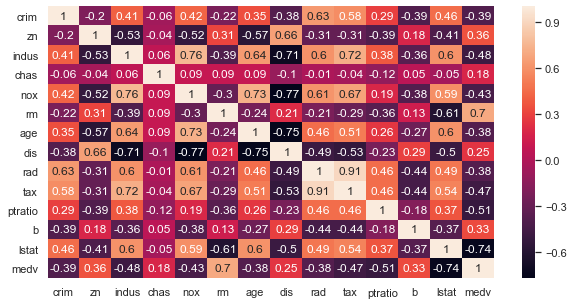

In [4]:
#Next, we create a correlation matrix that measures the linear relationships between the variables using heatmap function from seaborn lib
cor_matrix = df.corr().round(2)
sns.set(rc={'figure.figsize':(10, 5)})
sns.heatmap(data = cor_matrix, annot = True) # annot = True to print the values inside the square

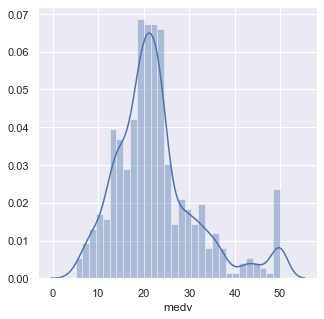

In [5]:
##To fit a linear regression model, we select those features which have a high correlation with our target variable medv. 
#The above correlation matrix shows that rm has a strong positive correlation with medv of + 0.70
# lstat has a high negative correlation with medv of -0.74
# ptratio has a negative correlation with medv of -0.51

## Also we avoid selecting variable that are highly correlated to each other to avoid multicollinearity
# We see that 'rad and tax' have a correlation of 0.91 and 'dis and age' have a correlation of -0.75 implying strong corerlation between them
# We are therefore going to avoid the selecting these variables for our linear regression model

# We will also stick to working with 3 predictor variables only 'lstat, rm and ptrati0' for our model to avoid overfitting problems.

##Let’s first plot the distribution of the target variable MEDV. We will use the distplot function from the seaborn library
sns.set(rc={'figure.figsize':(5, 5)})
sns.distplot(df['medv'], bins=30) # can also be written as: sns.distplot(price, bins=30)
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2B851C860>,
      dtype=object)

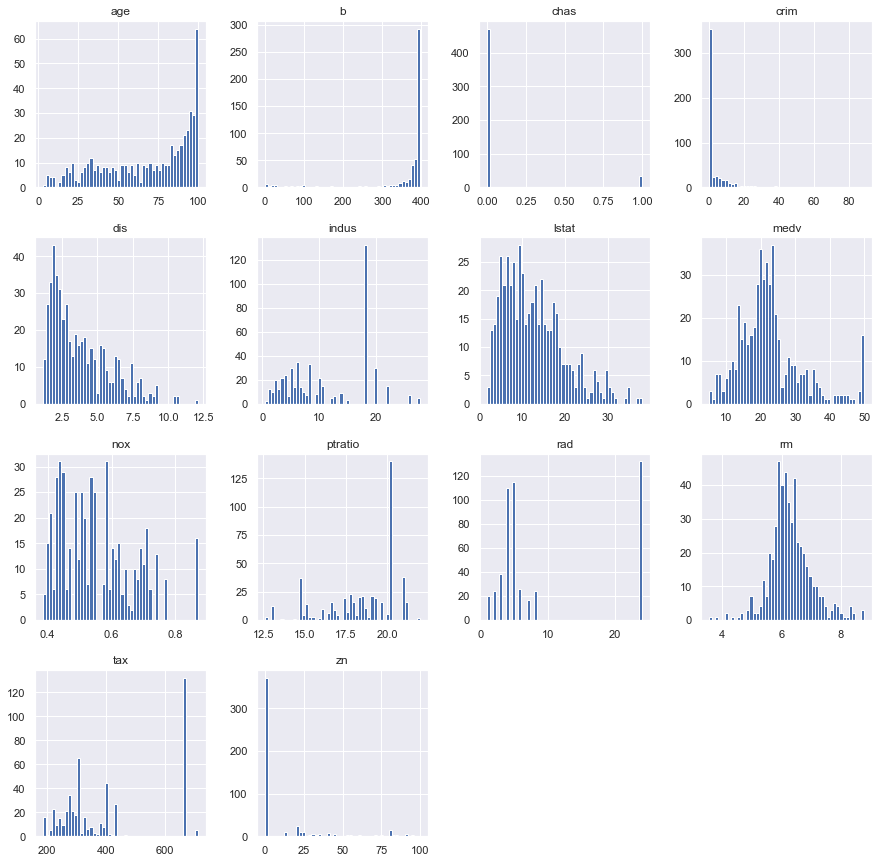

In [6]:
## The distribution os Home price above has a normal distribution. 

## Next we want to see distribution of all data variables
df.hist(bins=50, figsize=(15, 15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E2B953E7F0>,
      dtype=object)

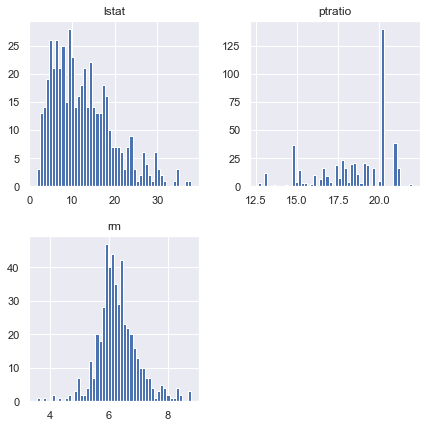

In [7]:
## If we want to plot only the three selected independent variables together
features.hist(bins=50, figsize=(7, 7))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Tue, 12 Nov 2019   Prob (F-statistic):           5.08e-88
Time:                        19:05:39   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

Text(0, 0.5, 'Price')

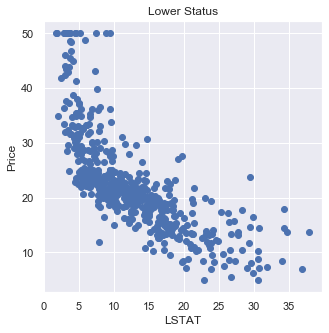

In [8]:
## We can now start with modeling a Simple Regression first using dependent varaible as 'price' and independent variable as 'lstat'
HousingPrice_model = ols("price ~ lstat", data = df).fit()
HousingPrice_model_summary = HousingPrice_model.summary()  #summarize our model
print(HousingPrice_model_summary)

## Ananlysis of the summary statistics
# Our R2 or Adj R2 value are 54%, not an indication of a good predictive model
## Since lstat has an absolute value of tstat as 24.52 > 1.96 and a pvalue 0 < 0.5, lstat is statistically significant so we need not drop
#the variable. The Durbin-Watson value of approx 2 means there is no autocorrelation but our model has less than 1 indicating
# a strong positive autocorrelation.

#We can review scatterplots individually in order to see correaltion between Price and selected predictor variable
plt.scatter(df.lstat, df.medv)
plt.title('Lower Status')
plt.xlabel('LSTAT')
plt.ylabel('Price')

Text(0, 0.5, 'Residuals')

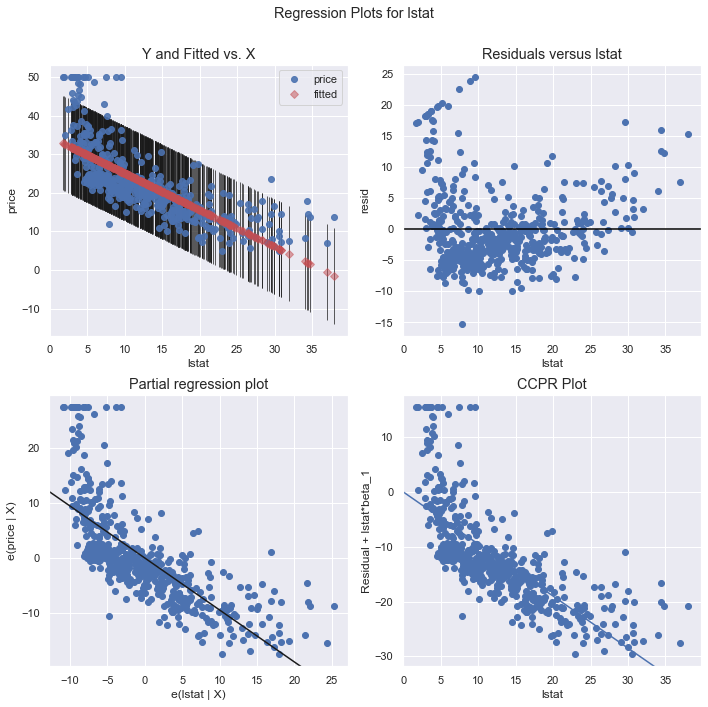

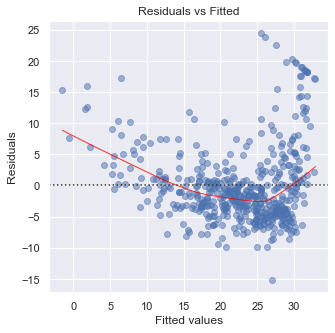

In [9]:
#First we need to check whether there is a linear relationship between the independent variables and the dependent variable in our model
#We can check scatter plot for this. The scatter plot above indicates a negative linear relationship between home price and lower status.

#This produces our four regression plots for lstat
fig = plt.figure(figsize=(10,10))

# pass in the model as the first parameter, then specify the Predictor variable we want to analyze
fig = sm.graphics.plot_regress_exog(HousingPrice_model, "lstat", fig=fig)

##Create Residual plot
dfresiduals = pd.concat([df.lstat, price], axis=1)
model_fitted_y = HousingPrice_model.fittedvalues
model_residuals = HousingPrice_model.resid

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data = dfresiduals, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.679
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     353.3
Date:                Tue, 12 Nov 2019   Prob (F-statistic):          2.69e-123
Time:                        19:05:41   Log-Likelihood:                -1553.0
No. Observations:                 506   AIC:                             3114.
Df Residuals:                     502   BIC:                             3131.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.5671      3.913      4.745      0.0

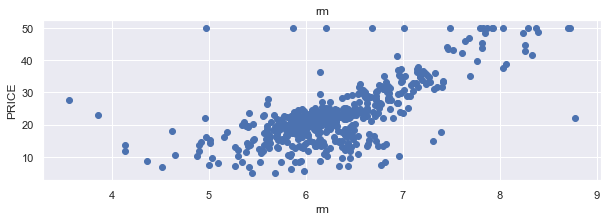

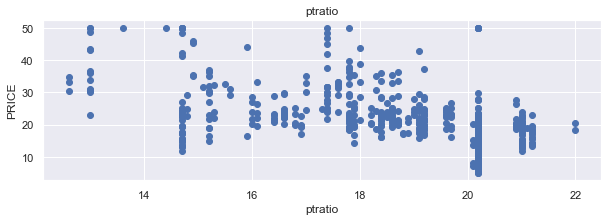

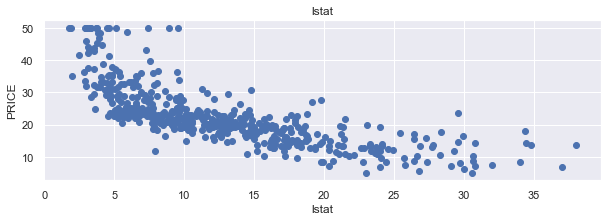

In [10]:
## Lets diagnose the above the above Residuals vs Fitted Plot. 
#The plot of residuals versus predicted values is useful for checking the assumption of linearity and homoscedasticity.
#If the model does not meet the linear model assumption, we would see residuals with a distinctive pattern or shape.
# For linearity assumption to be met, the red line through the scatterplot should be straight and horizontal, not curved.
#Is our data linear? No, the residuals are not scattered randomly around y = 0 line and has a slightly distinct shape to it.
#Also, the red line should be horizontal and our line is slightly curved. So our data has violated both the linearity and homoscedasticity assumptions.

# Our simple regression model was definitely not a good model so now we will add more independent variable to see if it improves our model.
## We can now include more predictor variables and construct a multiple regression model
# We will add 'rm' and 'ptratio' along with 'lstat' to predict 'price'
HousingPrice_MLmodel = ols("price ~ lstat + rm + ptratio", data = df).fit()
HousingPrice_MLmodel_summary = HousingPrice_MLmodel.summary()  #summarize our model
print(HousingPrice_MLmodel_summary)

## Ananlysis of the summary statistics
# Our R2 or Adj R2 has improved and the Adj R2 has increased to 67.7%, meaning 67.7% of variation in home price can be explained from our 
#independent variable.
## lstat, rm and ptratio all have statistically significant tstat values and p value of 0 <0.5, hence we need not drop any variable.
#The Durbin-Watson value of approx 2 means there is no autocorrelation but our model has still has a value less than 1 indicating
# a strong positive autocorrelation.

#Or we can plot scatterplots simultaneously in order to see correaltion between Price and selected predictor variable
features_names = ['rm','ptratio', 'lstat']  # List of variable names to be used for df[]
for i, col_name in enumerate(features_names):
    plt.figure(figsize=(10, 10))
    plt.subplot(3, len(features_names)/2 , i+1)
    plt.scatter(df[col_name], price, marker='o')
    plt.title(col_name)
    plt.xlabel(col_name)
    plt.ylabel('PRICE')

Text(0, 0.5, 'Residuals')

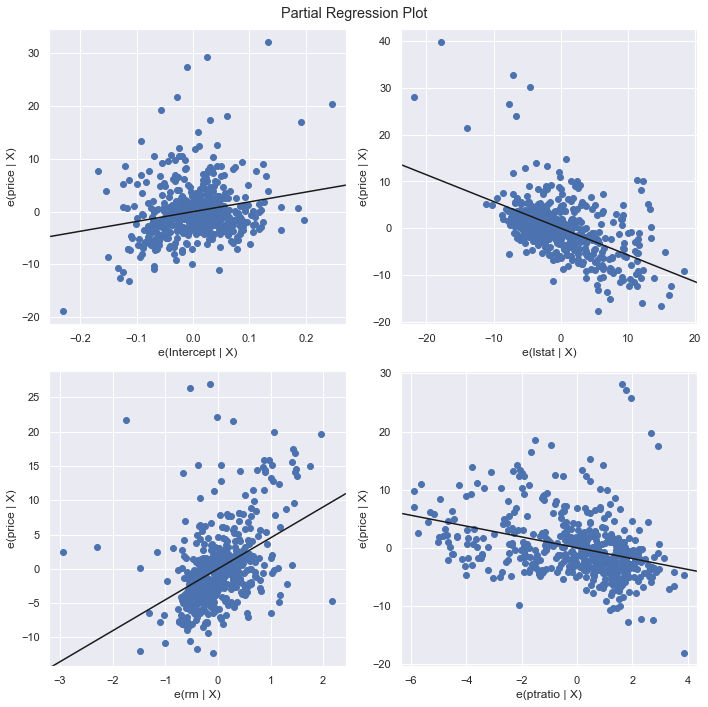

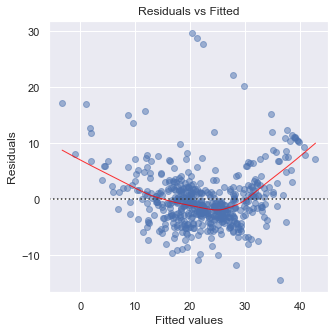

In [11]:
#As we introduced more independent variable for our linear regression model, we can check scatter plots again for any linear relationship
# between the independent variables and the dependent variable in our model. We need not draw scatterplot again to check relationship among
# independent vairable to check multicolinearity as we did so above in the heatmap.
#The scatter plots above indicate a negative linear relationship between home price and lower status.
# A positive relationship between home price and number of rooms and a weak relationship between home price and pupil to student ratio.

#Now we plot partial regression plots for our multiple regression model
fig = plt.figure(figsize=(10,10))
fig = sm.graphics.plot_partregress_grid(HousingPrice_MLmodel, fig=fig)

##Create Residual plot
dfresiduals = pd.concat([features, price], axis=1)
model_fitted_y = HousingPrice_MLmodel.fittedvalues
model_residuals = HousingPrice_MLmodel.resid

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, model_residuals, data = dfresiduals, lowess=True, scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

In [12]:
# In the residual vs fitted plot above, the red line is not horizontal and instead has a smile shape. 
# But the data does is more or less randomly scattered around the mean and does not have a very definitive shape.
# It therefore does not satisfy the linearity assumption but satisfies the homoscedasticity assumption.

In [13]:
## Now we will use Train Test method to check the prediction power of our model

In [14]:
## Now we will split the data into80:20 ratio for train and test and make predictions
## Since features and price were dataframe and series object, we will first convert them to array in order to use some functions
price = df[['medv']].values
features = df[['rm', 'lstat', 'ptratio']].values

x_train, x_test, y_train, y_test = train_test_split(features, price, test_size=0.2, random_state =10)
print("X train shape: ", x_train.shape)
print("y train shape: ", y_train.shape)
print("X test shape: ", x_test.shape)
print("y test shape: ", y_test.shape)

# fit a model
model = lm.LinearRegression()
model = model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print("y pred shape: ", y_pred.shape)

X train shape:  (404, 3)
y train shape:  (404, 1)
X test shape:  (102, 3)
y test shape:  (102, 1)
y pred shape:  (102, 1)


   Actual  Predicted
0    28.4  26.011272
1    31.1  31.548602
2    23.5  29.326174
3    26.6  28.048267
4    19.6  21.712314


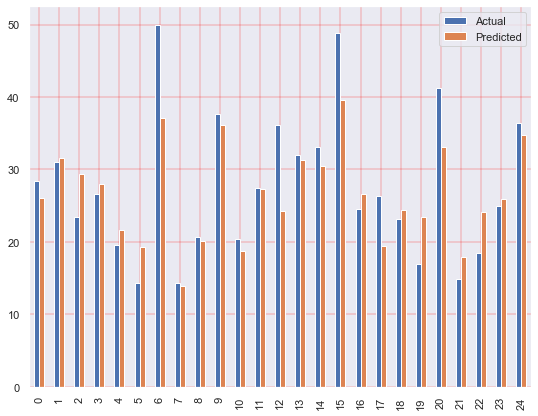

In [15]:
## Next we want to compare y_test with y_pred to see how far the predictions are
comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
print(comparison.head())

#We can also visualize comparison result as a bar graph, we will use 25 values
bar_chart = comparison.head(25)
bar_chart.plot(kind='bar',figsize=(9,7))
plt.grid(which='major', linestyle='-', linewidth='0.3', color='red')
plt.grid(which='minor', linestyle=':', linewidth='0.3', color='blue')
plt.show()

## We see the predicted values y_pred are pretty close to actual y_test values, meaning our model seems good so far

In [16]:
## We test the model's aaccuracy by looking at the difference between predicted values and actual values
## An accurate model would have residuals of zero. For regression algorithms, evaluation metrics commonly used are: MSE, MAE and RSME

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error is", round(mae, 2))
print("Mean Squared Error is", round(mse, 2))
print("Root Mean Squared Error is", round(rmse, 2))

Mean Absolute Error is 4.22
Mean Squared Error is 35.89
Root Mean Squared Error is 5.99


In [17]:
train_accuracy = model.score(x_train, y_train)
print("Training Accuracy: %.2f%%" % (train_accuracy*100.0))

test_accuracy = model.score(x_test, y_test)
print("Testing Accuracy: %.2f%%" % (test_accuracy*100.0))

rscore = metrics.r2_score(y_test, y_pred) ## Or we can use R2 score, gives the same result as test_accuracy
print("R2 score of prediction accuracy is: %.2f%%" % (rscore*100.0))

Training Accuracy: 67.35%
Testing Accuracy: 65.68%
R2 score of prediction accuracy is: 65.68%
